In [1]:
import copy
import numpy as np
from tqdm import tqdm

import torch

from update import LocalUpdate, test_inference
from models import CNNMnist, CNNCifar
from utils import *

import warnings
warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

In [2]:
n_train_epochs = 100
n_train_clients = 50
n_total_clients = 500


mal_usr_percentage = 0
target_hon = 4
target_mal = 6

# dataset = 'mnist'
dataset = 'cifar'
client_lr = 0.005
client_epochs = 10
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(torch.cuda.get_device_name(0))
# torch.cuda.set_device('cuda:0')
# print(torch.cuda.set_device('cuda'))
# print(torch.cuda.set_device(0))
# device = 'cuda'

NVIDIA GeForce GTX 1080 Ti


In [3]:
# load dataset and user groups
train_dataset, test_dataset, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, dataset)

# Training
clients = []
for i in range(n_train_epochs):
    # clients.append(np.random.choice(range(n_total_clients), n_train_clients, replace=False))
    clients.append(range(n_total_clients)[:n_train_clients])

train_loss_total = []
train_accuracy_total = []
train_recall_total = []

test_loss_total = []
test_accuracy_total = []
test_recall_total = []

attacker_detection_ratio = []

if dataset == 'mnist':
    global_model = CNNMnist()
elif dataset == 'cifar':
    global_model = CNNCifar()

# Saving:
torch.save({
    'model': global_model,
}, 'cifar.pth')



Files already downloaded and verified
Files already downloaded and verified


In [4]:
attack = [0, 1]
recalls = []

mal = [0, 10, 20, 30, 40]

In [5]:
mal_usr_percentage = 0

checkpoint = torch.load('cifar.pth')
global_model = checkpoint['model']
global_model.load_state_dict(global_model.state_dict())

train_accuracy = []
train_recall = []

# load dataset and user groups
train_dataset, test_dataset, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, dataset)

# Training
clients = []
for i in range(n_train_epochs):
    # clients.append(np.random.choice(range(n_total_clients), n_train_clients, replace=False))
    clients.append(np.random.choice(range(n_total_clients), n_train_clients, replace=False))
    

# Send the model to the device and then set it to train mode
global_model.to(device)
global_model.train() 

# hold the initial global weights
global_weights = global_model.state_dict()
# just attacks
for epoch in tqdm(range(n_train_epochs)):

    selected_users = clients[epoch]
        
    local_weights, local_losses = [], []
    
    for user in selected_users:
        local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

        w, loss = local_model.update_weights(
            model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr)
        
        local_weights.append(copy.deepcopy(w))
        local_losses.append(copy.deepcopy(loss))
    
    loss_avg = sum(local_losses) / len(selected_users)
    
    train_loss_total.append(loss_avg)
    
    # update global weights
    global_weights = average_weights(local_weights)

    # update global weights
    global_model.load_state_dict(global_weights)

    # Calculate avg training accuracy over all users at every epoch
    train_acc = 0
    train_rec = 0
    # evaluation mode of the model
    global_model.eval()

    for client in selected_users:
        local_model = LocalUpdate(dataset = train_dataset, clients = user_groups[client])
        
        acc, loss, rec = local_model.inference(model = global_model)
        train_acc += acc
        train_rec += rec
        
    train_acc /= len(selected_users)
    train_rec /= len(selected_users)
    print(train_acc)
    train_accuracy.append(train_acc)
    train_recall.append(train_rec)

Files already downloaded and verified
Files already downloaded and verified


  1%|          | 1/100 [00:18<30:40, 18.59s/it]

0.11333333333333337


  2%|▏         | 2/100 [00:34<27:20, 16.74s/it]

0.09733333333333338


  3%|▎         | 3/100 [00:50<26:49, 16.59s/it]

0.1066666666666667


  4%|▍         | 4/100 [01:06<26:30, 16.57s/it]

0.16266666666666674


  5%|▌         | 5/100 [01:25<27:17, 17.24s/it]

0.17866666666666664


  6%|▌         | 6/100 [01:46<29:18, 18.71s/it]

0.19333333333333325


  7%|▋         | 7/100 [02:10<31:17, 20.19s/it]

0.16400000000000003


  8%|▊         | 8/100 [02:27<29:41, 19.36s/it]

0.1920000000000001


  9%|▉         | 9/100 [02:47<29:28, 19.43s/it]

0.2306666666666667


 10%|█         | 10/100 [03:06<29:08, 19.43s/it]

0.16800000000000007


 11%|█         | 11/100 [03:26<28:43, 19.37s/it]

0.1946666666666668


 12%|█▏        | 12/100 [03:45<28:17, 19.29s/it]

0.1613333333333334


 13%|█▎        | 13/100 [04:04<27:48, 19.18s/it]

0.17200000000000004


 14%|█▍        | 14/100 [04:23<27:44, 19.36s/it]

0.1720000000000001


 15%|█▌        | 15/100 [04:46<28:47, 20.32s/it]

0.17333333333333342


 16%|█▌        | 16/100 [05:08<29:15, 20.89s/it]

0.20800000000000007


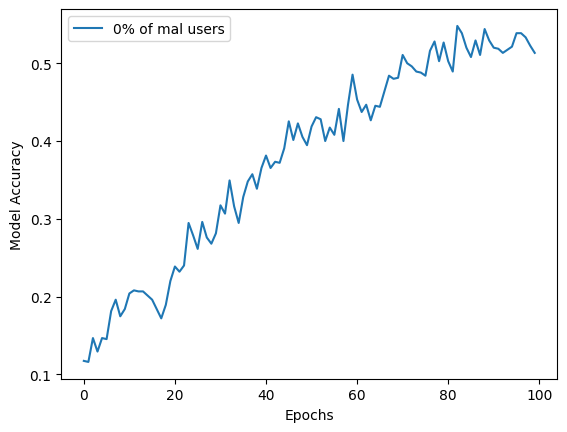

In [ ]:
plt.plot(range(n_train_epochs), train_accuracy, label = str(0) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
# plt.ylim(0, 1)

plt.legend()
plt.show()

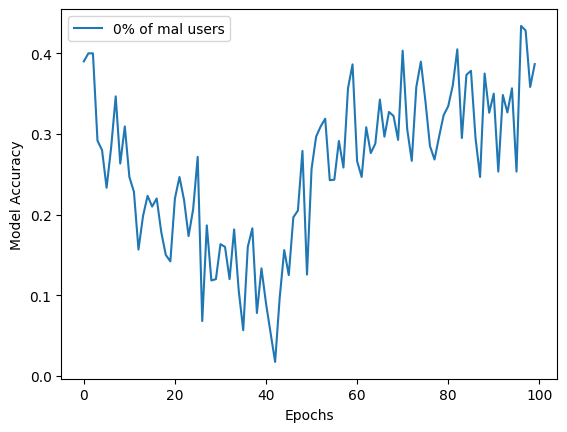

In [ ]:
plt.plot(range(n_train_epochs), train_recall, label = str(0) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Model Accuracy")
plt.legend()
plt.show()

In [ ]:
# test_acc, test_ls, test_rec = test_inference(global_model, test_dataset)
print(test_inference(global_model, test_dataset))

(0.5423, 1.448503777950625, 0.381999618000382)


In [5]:
for att in attack:
    last_epoch_recall = []

    for mal_usr_percentage in mal:
        
        train_dataset, _, user_groups, attackers = get_dataset(mal_usr_percentage / 100, target_hon, target_mal, n_total_clients, dataset)

        checkpoint = torch.load('cifar.pth')
        global_model = checkpoint['model']
        global_model.load_state_dict(global_model.state_dict())

        attack_ratio = 0
        
        print("Running experiment with " + str(mal_usr_percentage) + "% malicious clients")

        # Send the model to the device and then set it to train mode
        global_model.to(device)
        global_model.train()
    
        # hold the initial global weights
        global_weights = global_model.state_dict()
        
        train_loss , train_accuracy, train_recall = [], [], []
        test_loss , test_accuracy, test_recall = [], [], []


        for epoch in tqdm(range(n_train_epochs)):
            if att == 1:
                local_weights_fake, local_losses_fake = [], []
                
                global_model.train()
            
                selected_users = clients[epoch]

                for user in selected_users:
                    local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

                    w, loss = local_model.update_weights(
                        model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr, fake=True)
                    
                    local_weights_fake.append(copy.deepcopy(w))
                    local_losses_fake.append(copy.deepcopy(loss))

                
                local_losses_fake = apply_ldp(local_losses_fake, epsilon=1.0, sensitivity=0.0001)
                
                info = (local_losses_fake, local_weights_fake, selected_users)
                
                selected_users, attackers_found = eliminate_largest_diff(info, n_train_clients)
                            
                count = sum(1 for item in attackers_found if item in attackers)
                
                if mal_usr_percentage > 0:
                    attack_ratio += (count / ((mal_usr_percentage / 100) * n_train_clients))
                            
            elif att == 0:
                selected_users = clients[epoch]
                
            local_weights, local_losses = [], []
            
            for user in selected_users:
                local_model = LocalUpdate(dataset=train_dataset, clients=user_groups[user])

                w, loss = local_model.update_weights(
                    model=copy.deepcopy(global_model), local_epochs=client_epochs, learning_rate=client_lr)
                
                local_weights.append(copy.deepcopy(w))
                local_losses.append(copy.deepcopy(loss))
            
            loss_avg = sum(local_losses) / len(selected_users)
            
            train_loss_total.append(loss_avg)
            
            # update global weights
            global_weights = average_weights(local_weights)
            # update global weights
            global_model.load_state_dict(global_weights)

            # Calculate avg training accuracy over all users at every epoch
            train_acc = 0
            train_rec = 0
            # evaluation mode of the model
            global_model.eval()

            for client in selected_users:
                local_model = LocalUpdate(dataset = train_dataset, clients = user_groups[client])
                
                acc, loss, rec = local_model.inference(model = global_model)
                train_acc += acc
                train_rec += rec
                
            train_acc /= len(selected_users)
            train_rec /= len(selected_users)
            
            train_accuracy.append(train_acc)
            train_recall.append(train_rec)

            # Test inference after each epoch
            test_acc, test_ls, test_rec = test_inference(global_model, test_dataset)

            test_accuracy.append(test_acc)
            test_loss.append(test_ls)
            test_recall.append(test_rec)
            
        
        last_epoch_recall.append(test_recall[-1])
        
        if att == 1:
            attack_ratio /= n_train_epochs
            if attack_ratio > 1:
                attack_ratio = 1
            attacker_detection_ratio.append(attack_ratio)
            train_accuracy_total.append(train_accuracy)
            train_loss_total.append(train_loss)
            train_recall_total.append(train_recall)

            test_accuracy_total.append(test_accuracy)
            test_loss_total.append(test_loss)
            test_recall_total.append(test_recall)

    recalls.append(last_epoch_recall)


Files already downloaded and verified


Files already downloaded and verified
Running experiment with 0% malicious clients


100%|██████████| 100/100 [44:33<00:00, 26.74s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 10% malicious clients


100%|██████████| 100/100 [45:21<00:00, 27.21s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 20% malicious clients


100%|██████████| 100/100 [44:41<00:00, 26.81s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 30% malicious clients


100%|██████████| 100/100 [44:40<00:00, 26.80s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 40% malicious clients


100%|██████████| 100/100 [42:33<00:00, 25.54s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 0% malicious clients


100%|██████████| 100/100 [1:13:24<00:00, 44.04s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 10% malicious clients


100%|██████████| 100/100 [1:13:47<00:00, 44.28s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 20% malicious clients


100%|██████████| 100/100 [1:19:17<00:00, 47.58s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 30% malicious clients


100%|██████████| 100/100 [1:20:27<00:00, 48.27s/it]


Files already downloaded and verified
Files already downloaded and verified
Running experiment with 40% malicious clients


 19%|█▉        | 19/100 [14:45<1:06:12, 49.05s/it]

In [9]:
print(recalls)

[[0.227999772000228, 0.240999759000241, 0.243999756000244, 0.238999761000239, 0.260999739000261]]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


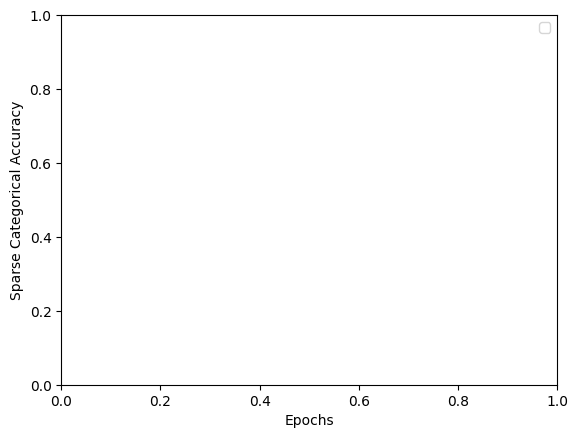

In [ ]:
#plot for only attacking
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(test_accuracy_total):

    plt.plot(epochs, model_acc, label = str(mal[cnt]) + "% of mal users")
plt.xlabel("Epochs")
plt.ylabel("Sparse Categorical Accuracy")
plt.legend()
plt.show()

In [ ]:
import matplotlib
import matplotlib.pyplot as plt
matplotlib.use('Agg')


epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_rec in enumerate(test_recall_total):

    plt.plot(epochs, model_rec, label = str(mal[cnt]) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Source Class Recall")
plt.legend()
plt.savefig('save/rec_many_largest_diff.png')

In [ ]:
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_loss in enumerate(test_loss_total):

    plt.plot(epochs, model_loss, label = str(mal[cnt]) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("CrossEntropy Loss")
plt.legend()
plt.savefig('save/loss_many_largest_diff.png')

In [ ]:
plt.figure()
epochs = [x for x in range(0, n_train_epochs)]
for cnt, model_acc in enumerate(test_accuracy_total):

    plt.plot(epochs, model_acc, label = str(mal[cnt]) + "% of mal users")


plt.xlabel("Epochs")
plt.ylabel("Sparse Categorical Accuracy")
plt.legend()
plt.savefig('save/accs_many_largest_diff.png')

In [ ]:
plt.figure()

plt.plot(mal[1:], attacker_detection_ratio[1:], 'o',  label = "Attackers detection ratio", linestyle = "-", linewidth = .4)
plt.xlabel("Malicious users %")
plt.ylabel("Percentage of attackers detected")
plt.legend()
plt.savefig('save/attackers_largest_diff.png')

IndexError: list index out of range

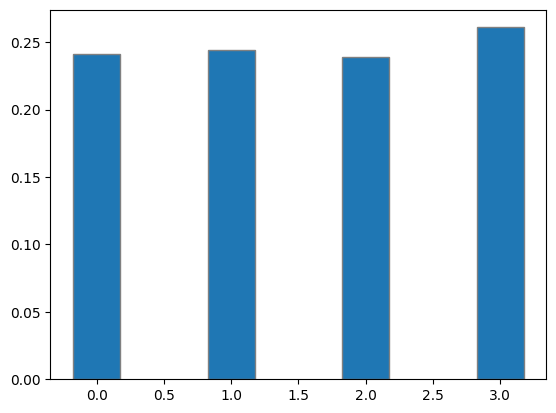

In [ ]:
plt.figure()
bar_width = 0.35

r1 = np.arange(len(mal[1:]))
r2 = [x + bar_width for x in r1]

plt.bar(r1, recalls[0][1:], width=bar_width, edgecolor='grey', label='With Defense')
plt.bar(r2, recalls[1][1:], width=bar_width, edgecolor='grey', label='Without Defense')

plt.title('Effect of Defense Mechanism on Source Class Recall in Poisoning Attacks in FL')
plt.xlabel('Malicious Users Percentage', fontweight='bold')
plt.ylabel('Source Class Recall', fontweight='bold')

plt.xticks([r + bar_width for r in range(len(recalls[0][1:]))], mal[1:])

plt.legend()
plt.savefig('save/comparison_largest_diff.png')